In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
import re


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [14]:
class RPSDataset(Dataset):
    def __init__(self, data_dir, transform=None, is_train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.is_train = is_train
        self.img_paths = []
        self.labels = []
        self.class_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2}
        
        if self.is_train:
            for class_name, idx in self.class_to_idx.items():
                class_dir = os.path.join(data_dir, class_name)
                for img_name in os.listdir(class_dir):
                    self.img_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(idx)
        else:
            for img_name in os.listdir(data_dir):
                class_name = re.match(r'[a-zA-Z]+', img_name).group(0)  # Adjusted this line
                if class_name in self.class_to_idx:
                    self.labels.append(self.class_to_idx[class_name])
                    self.img_paths.append(os.path.join(data_dir, img_name))
                else:
                    print(f"Warning: Skipping {img_name} as class name {class_name} is not recognized")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB') 
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = RPSDataset(data_dir='data/Rock-Paper-Scissors/train', transform=train_transforms, is_train=True)
validation_dataset = RPSDataset(data_dir='data/Rock-Paper-Scissors/validation', transform=valid_test_transforms, is_train=False)
test_dataset = RPSDataset(data_dir='data/Rock-Paper-Scissors/test', transform=valid_test_transforms, is_train=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [16]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)  
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 3)  

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
def train_model_with_early_stopping(model, criterion, optimizer, train_loader, validation_loader, num_epochs=25, patience=5):
    best_loss = float('inf')
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(train_accuracy)
        
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        validation_losses.append(validation_loss/len(validation_loader))
        validation_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss/len(validation_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        if validation_loss < best_loss:
            best_loss = validation_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
    
    model.load_state_dict(torch.load('best_model.pth'))
    

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    return model


Epoch 1/100, Train Loss: 1.8313, Train Accuracy: 47.50%, Validation Loss: 1.5403, Validation Accuracy: 48.48%
Epoch 2/100, Train Loss: 0.6370, Train Accuracy: 72.90%, Validation Loss: 0.6341, Validation Accuracy: 69.70%
Epoch 3/100, Train Loss: 0.4883, Train Accuracy: 79.52%, Validation Loss: 0.7422, Validation Accuracy: 72.73%
Epoch 4/100, Train Loss: 0.3898, Train Accuracy: 84.88%, Validation Loss: 0.4355, Validation Accuracy: 84.85%
Epoch 5/100, Train Loss: 0.3184, Train Accuracy: 87.62%, Validation Loss: 0.2119, Validation Accuracy: 87.88%
Epoch 6/100, Train Loss: 0.2866, Train Accuracy: 89.13%, Validation Loss: 0.2134, Validation Accuracy: 90.91%
Epoch 7/100, Train Loss: 0.2372, Train Accuracy: 91.03%, Validation Loss: 0.3383, Validation Accuracy: 90.91%
Epoch 8/100, Train Loss: 0.2500, Train Accuracy: 90.63%, Validation Loss: 0.1574, Validation Accuracy: 93.94%
Epoch 9/100, Train Loss: 0.1907, Train Accuracy: 92.90%, Validation Loss: 0.2262, Validation Accuracy: 90.91%
Epoch 10/1

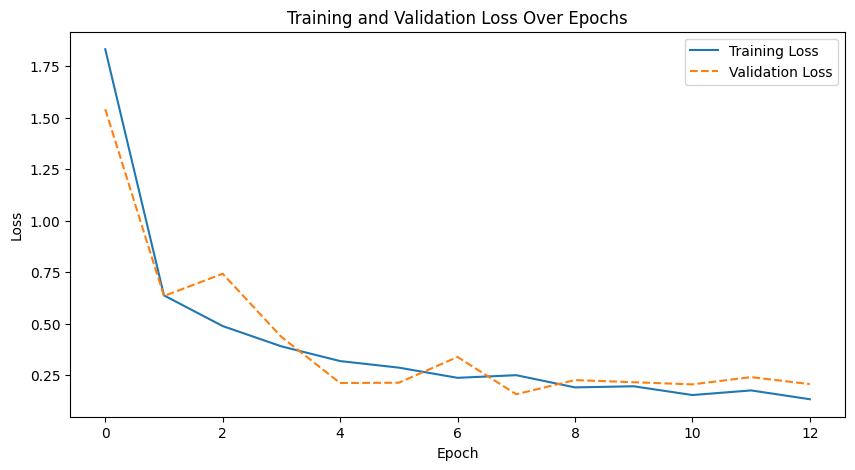

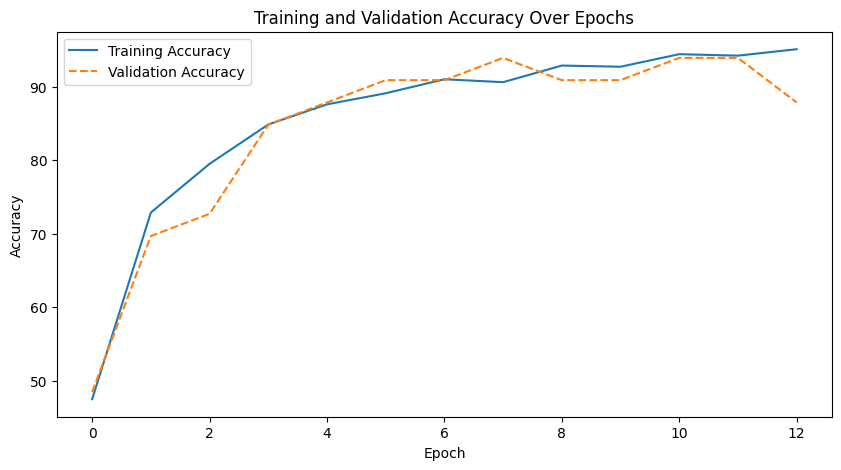

In [18]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


trained_model = train_model_with_early_stopping(model, criterion, optimizer, train_loader, validation_loader, num_epochs=100, patience=5)


In [19]:
model.eval()

correct = 0
total = 0
test_loss = 0.0


criterion = nn.CrossEntropyLoss()


with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=16, shuffle=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / total:.4f}")
print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Test Loss: 0.0135
Accuracy on test set: 94.35%
